In [1]:
import game

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np

import agent

In [2]:
def visualize(stateHistory, actionHistory, rewardHistory, N):
    inventory = stateHistory[:, 0, :]
    orders = actionHistory[:, 1, :]
    serviceTimes = actionHistory[:, 0, :]
    reorderPoints = stateHistory[:, 1, :]
    
    print("Time Series")
    for i in range(2, -1, -1):
        plt.figure(figsize=(20, 4))
        
        alpha = 1 if i == 2 else 0.3
#         plt.step(range(N+1), inventory[:, i] * np.roll(np.sign(orders[:, i]), -1), label="inventory")        
        plt.plot(range(N+1), inventory[:, i], label="inventory", alpha=alpha, c='b', linestyle='--', drawstyle='steps')
        plt.step(range(N+1), orders[:, i], label="order quantity", c='orange')
        if i == 2:
            plt.step(range(N+1), reorderPoints[:, i], label="reorder point", c='green')
        plt.ylim((-5, 30))
        plt.legend()
    plt.show()

    print("Service Time")
    for i in range(2, -1, -1):
        plt.figure(figsize=(20, 4))
        plt.step(range(N+1), serviceTimes[:, i], label="service time")
        plt.ylim((-5, 30))
        plt.legend()
    plt.show()

    
    print("Inventory")
    for i in range(2, -1, -1):
        plt.figure(figsize=(20, 4))
        plt.step(range(N+1), inventory[:, i] * np.sign(orders[:, i]), label="inventory")
        plt.ylim((-5, 30))
        plt.legend()
    plt.show()

    print("Rewards")
    plt.figure(figsize=(20, 4))
    plt.step(range(N+1), rewardHistory)
    plt.show()

In [3]:
learningParams = {
    "gamma": 0.2,
    "alpha": 1,
    "epsilon": 0.5
}

envParams = {
    "inventoryCost": [5, 1000, 1000], # [1000, 5, 1000], #
    "muDemand": 2,
    "stdDemand": 0, #0.1, #1,
    "retailerOrder": 10,
    "stockoutCost": 50000,
    "N": 1000
}

In [4]:
plannerAgent = agent.PlannerWithPolicyGradient(learningParams, envParams["retailerOrder"])
plannerAgent.policy_estimator.stdVal = 10

Time Series


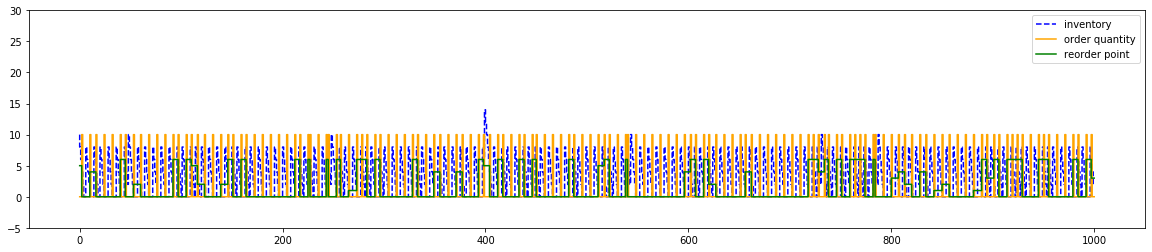

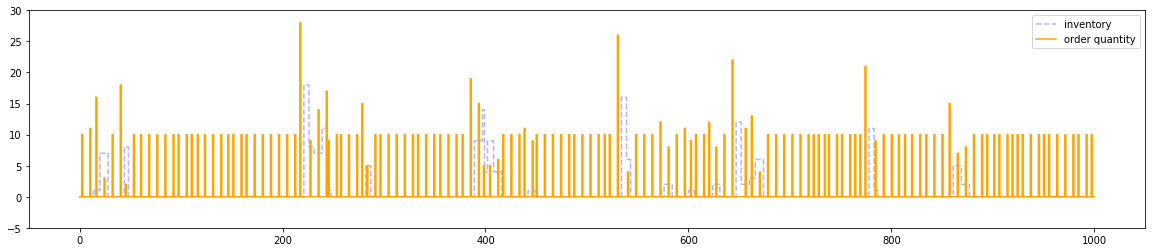

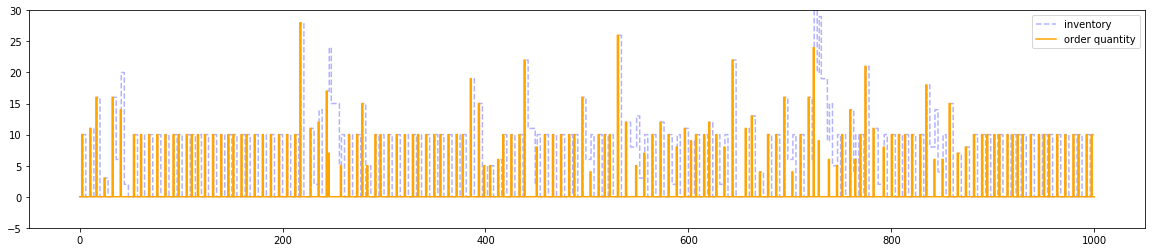

Service Time


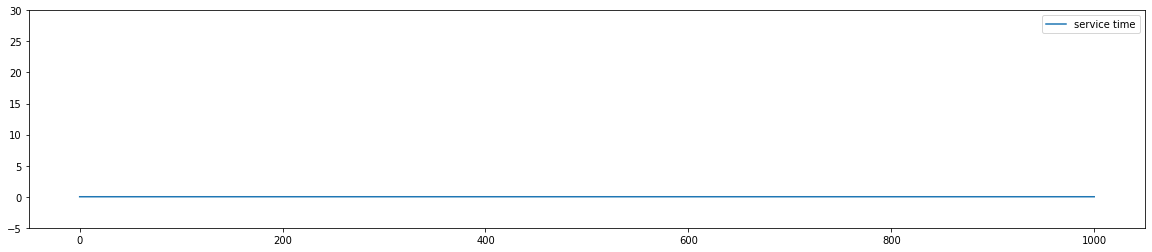

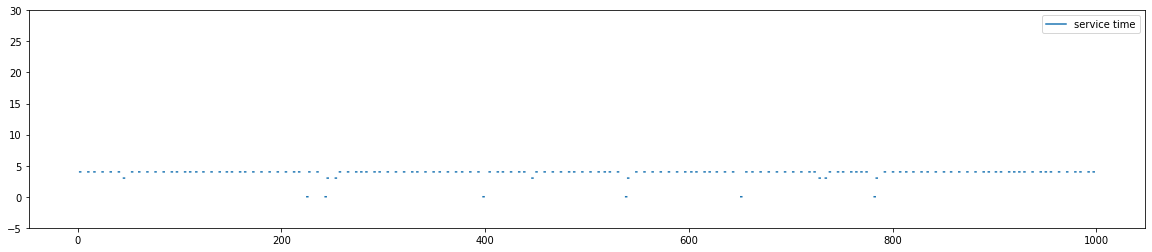

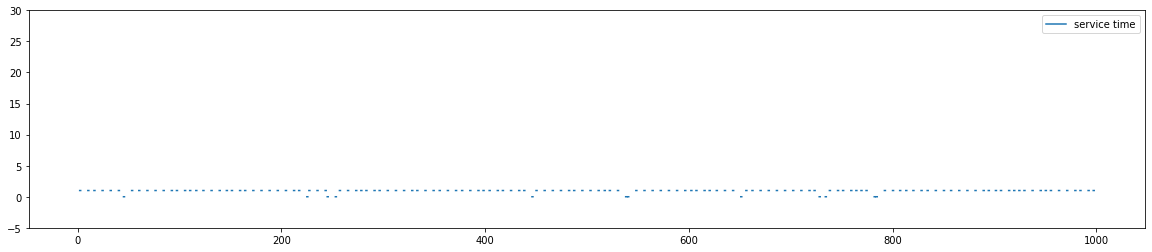

Inventory


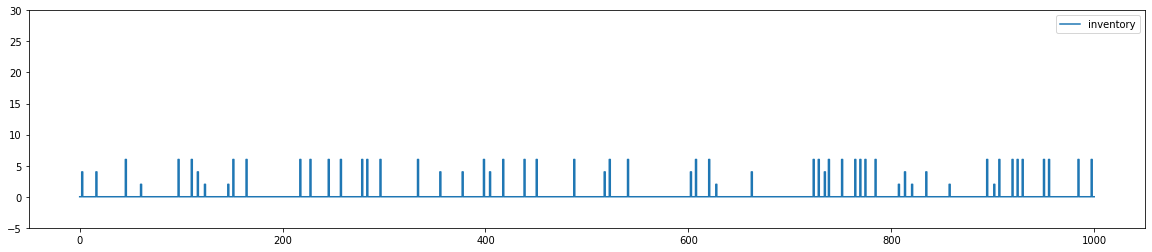

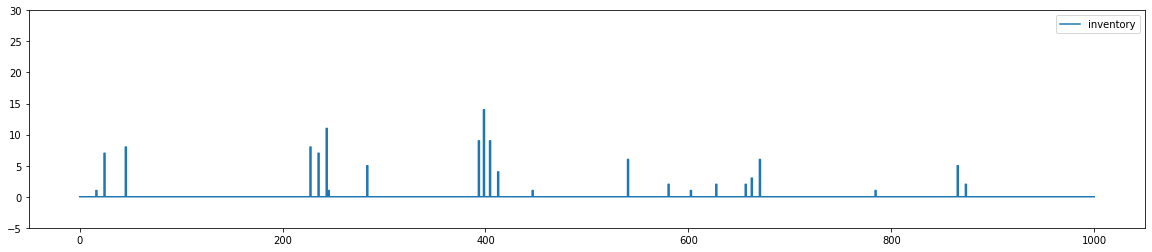

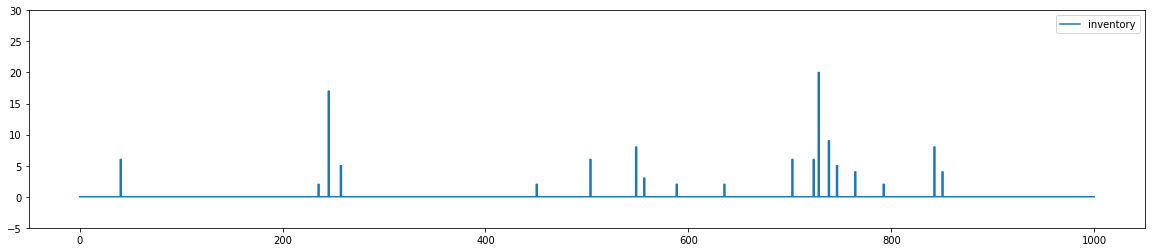

Rewards


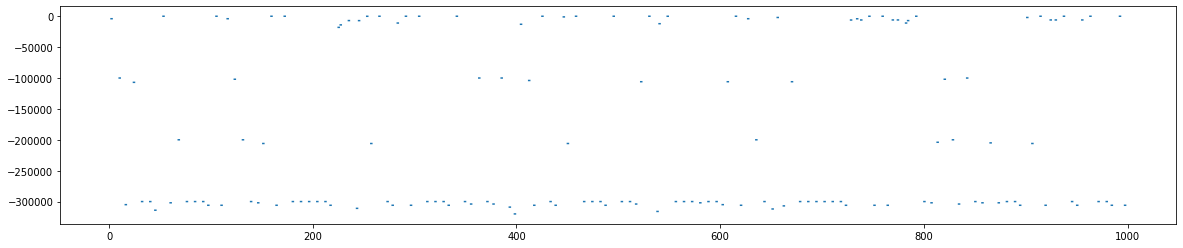

In [5]:
# play the game while training
stateHistory, actionHistory, rewardHistory, experiences = game.runEpisode(envParams, plannerAgent, train=False)

visualize(stateHistory, actionHistory, rewardHistory, envParams["N"])


/home/eek31/PycharmProjects/safety-stock-rl/agent.py:411: RuntimeWarning: overflow encountered in exp
  target = 10 * np.exp((target-1000) / 1000)


-49476.95
(array([0.3230704 , 0.41941154, 0.0859232 ], dtype=float32), array([10., 10.,  1.], dtype=float32))


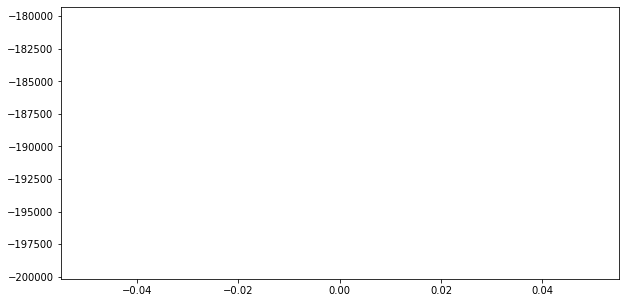

-247784.66
(array([5.6627088, 2.8687994, 1.7686002], dtype=float32), array([14., 10.,  0.], dtype=float32))


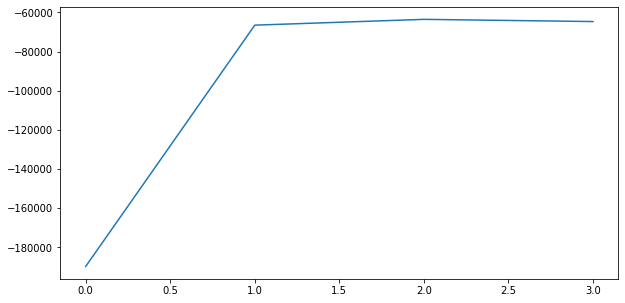

-399249.3
(array([11.163043 ,  6.8539066,  2.5536563], dtype=float32), array([15., 15.,  0.], dtype=float32))


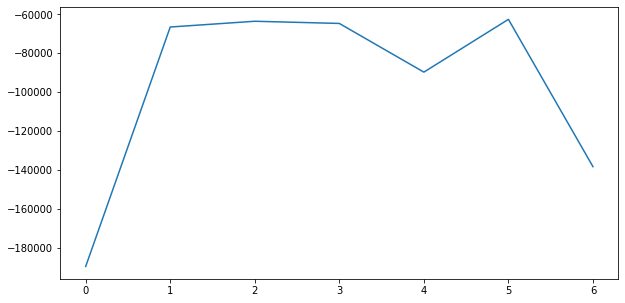

-400375.3
(array([17.268415, 11.789099,  4.510994], dtype=float32), array([16., 10.,  0.], dtype=float32))


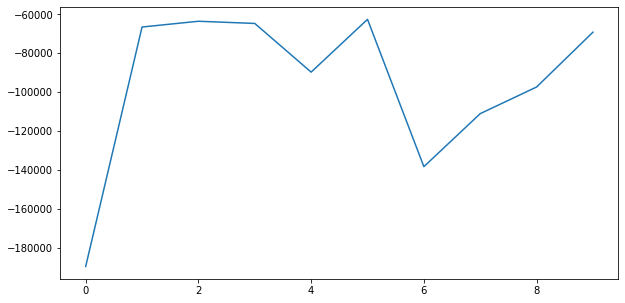

-791737.5
(array([23.15975 , 15.357947,  4.723059], dtype=float32), array([21., 14.,  2.], dtype=float32))


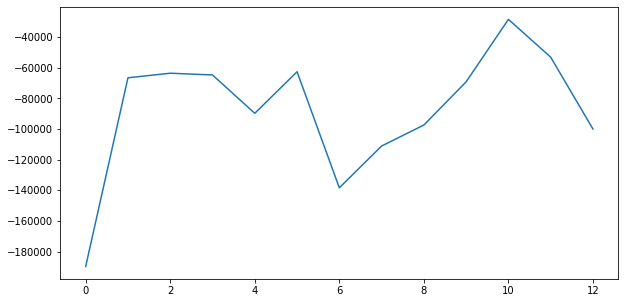

-320595.47
(array([27.597692, 18.062683,  6.911618], dtype=float32), array([15., 10.,  0.], dtype=float32))


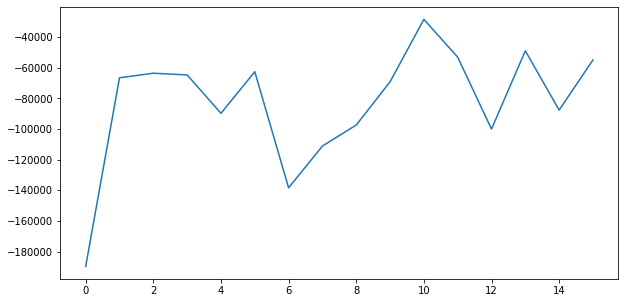

-249003.86
(array([27.166084 , 16.719364 ,  4.5895004], dtype=float32), array([19., 10.,  6.], dtype=float32))


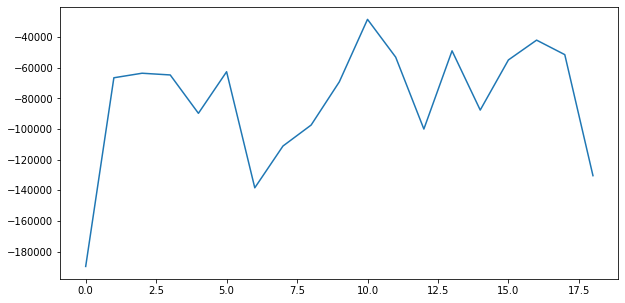

-328346.97
(array([32.70139 , 16.990408,  5.955388], dtype=float32), array([16., 16.,  0.], dtype=float32))


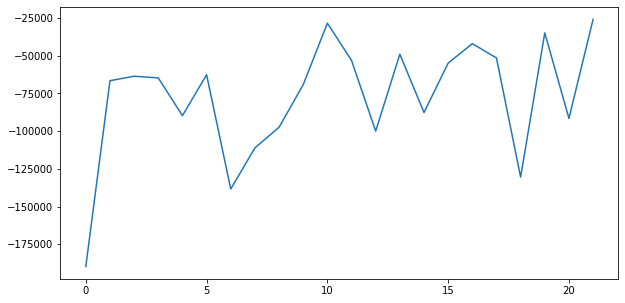

-420148.9
(array([32.320045, 14.672989,  6.58807 ], dtype=float32), array([21., 18.,  6.], dtype=float32))


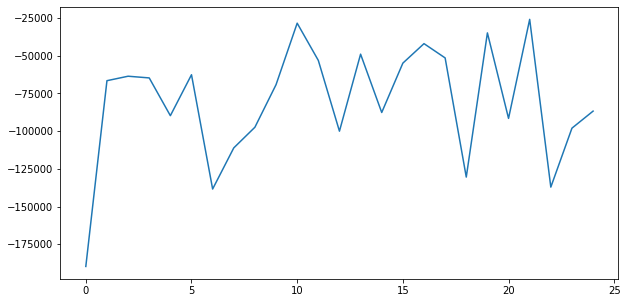

-291682.84
(array([22.447886 , 13.3349905,  7.1349363], dtype=float32), array([26., 10.,  6.], dtype=float32))


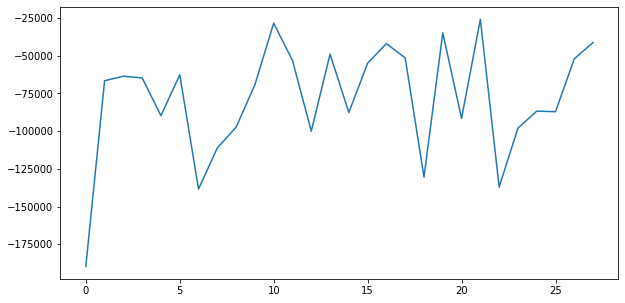

-360951.75
(array([23.512869 , 11.822473 ,  6.1929593], dtype=float32), array([10., 10.,  6.], dtype=float32))


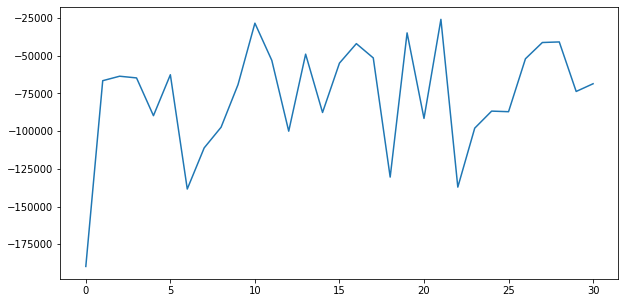

-301176.56
(array([24.304838 , 22.48128  ,  4.7181935], dtype=float32), array([29., 22.,  6.], dtype=float32))


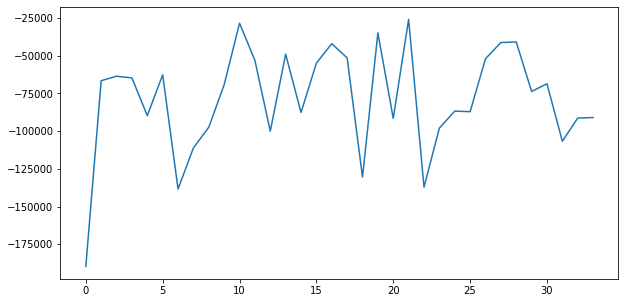

-401298.03
(array([17.88598 , 10.646871,  6.216408], dtype=float32), array([29., 22.,  0.], dtype=float32))


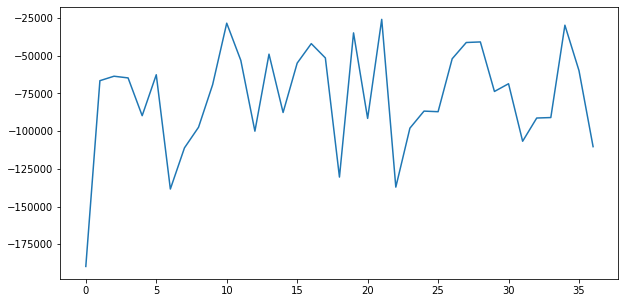

-173297.98
(array([38.435406 , 21.790556 ,  7.7452016], dtype=float32), array([30., 15.,  6.], dtype=float32))


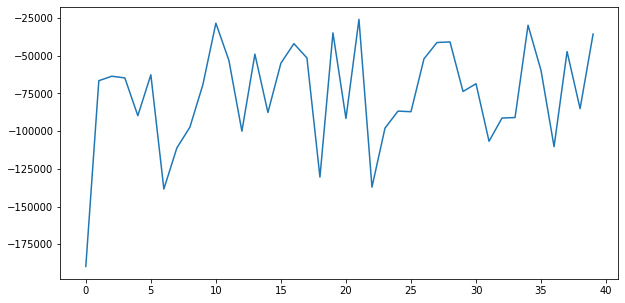

-207869.22
(array([28.968922, 27.484804,  2.841715], dtype=float32), array([24., 24.,  0.], dtype=float32))


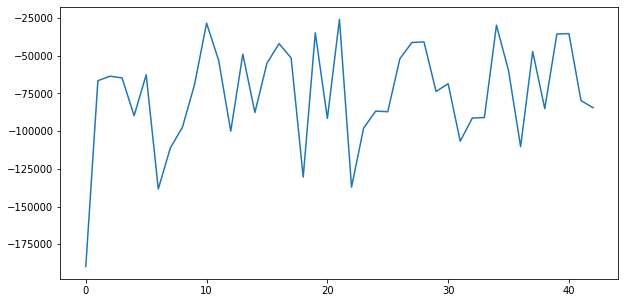

-240532.6
(array([30.484688, 22.39529 ,  7.258543], dtype=float32), array([30., 10.,  6.], dtype=float32))


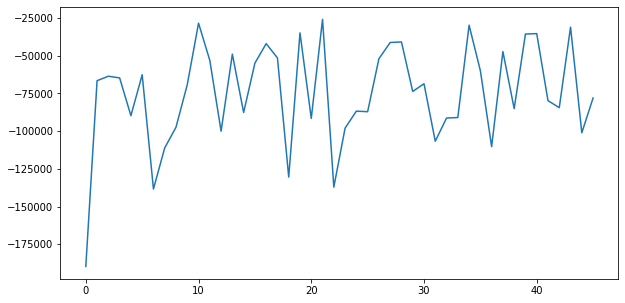

-240759.88
(array([28.64331 , 31.565414,  6.311839], dtype=float32), array([30., 30.,  6.], dtype=float32))


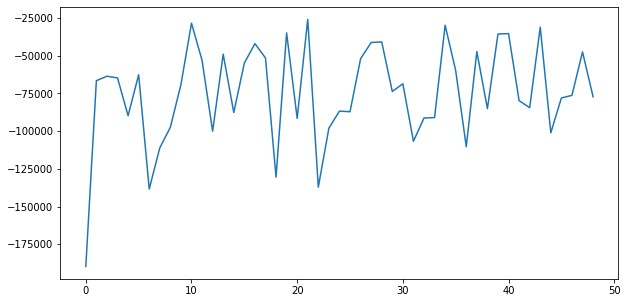

In [6]:
rewardsAll = []
experienceAll = []
N = 50
# plannerAgent.policy_estimator.stdVal = 10
# decreaseRate = plannerAgent.policy_estimator.stdVal / N
for i in tqdm_notebook(range(N)):
# play the game while trainings
    _, _, rewards, experiences = game.runEpisode(envParams, plannerAgent, train=True)
    
    # only consider steady state rewards
    rewards = rewards[-100:]
    averageRewards = np.nansum(rewards)/np.count_nonzero(~np.isnan(rewards))
    rewardsAll.append(averageRewards)
    experienceAll.extend(experiences)

    if (i % 3 == 0): # & (i > 0):
        print(plannerAgent.value_estimator.predict(np.array([0, 0, 0])))
        print(plannerAgent.policy_estimator.predict(np.array([0, 0, 0]), capacity=[30, 30, 30], retailerOrderQty=10))
        plt.figure(figsize=(10, 5))
        plt.plot(rewardsAll)
        plt.show()
        
#     # reduce exploration over time
#     plannerAgent.policy_estimator.stdVal -= decreaseRate

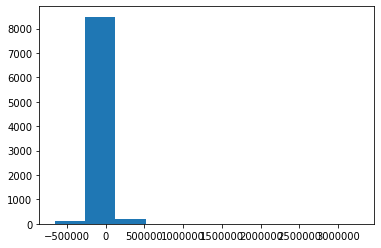

/home/eek31/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


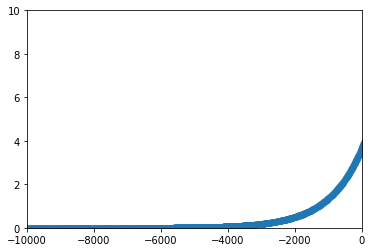

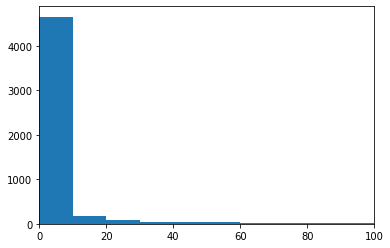

In [7]:
# visualize target recorder -> to determine exp
plt.hist(plannerAgent.policy_estimator.targetRecorder)
plt.show()

y = [10 * np.exp((x-1000) / 1000) for x in plannerAgent.policy_estimator.targetRecorder]
# y = [10 * np.exp(x / 2000) for x in plannerAgent.policy_estimator.targetRecorder]
plt.scatter(plannerAgent.policy_estimator.targetRecorder, y, alpha=0.2)
plt.ylim((0, 10))
plt.xlim((-10000, 0))
plt.show()

plt.hist(y, range=(0, 100))
plt.xlim((0, 100))
plt.show()

In [8]:
# import pandas as pd

# # visited states
# visitDF = pd.DataFrame([e[2][0] for e in experienceAll])
# visitDF[2].value_counts(), visitDF[1].value_counts(), visitDF[0].value_counts()

In [9]:
# for a in [[10, 0, 0], [10, 0, 2], [10, 0, 4]]:
#     print(plannerAgent.value_estimator.predict(np.array(a)))

In [10]:
plannerAgent.policy_estimator.predict(np.array([0, 0, 0]), capacity=[30, 30, 30], retailerOrderQty=10)

(array([24.580378, 11.427505,  6.248802], dtype=float32),
 array([30., 13.,  6.], dtype=float32))

[5, 1000, 1000]
Time Series


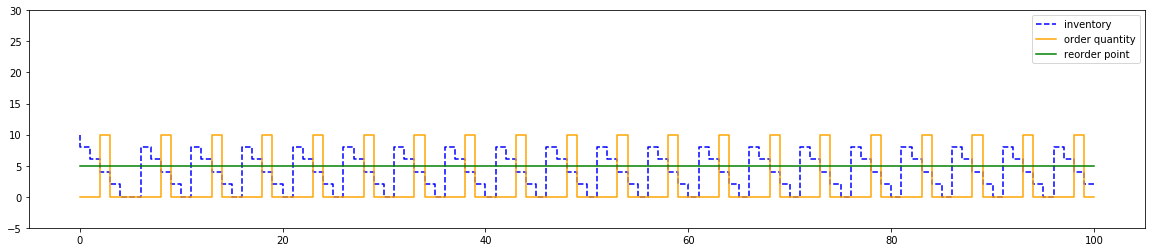

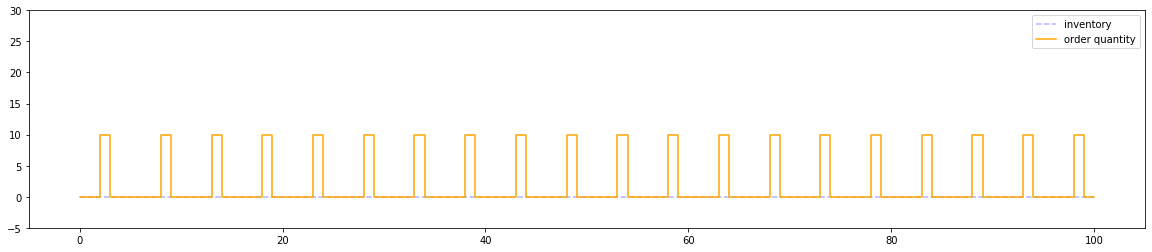

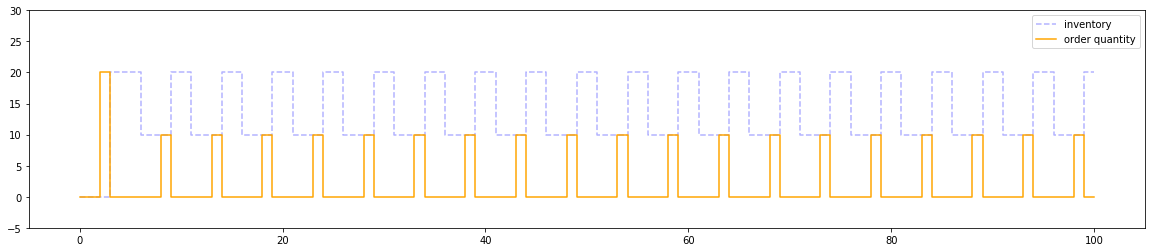

Service Time


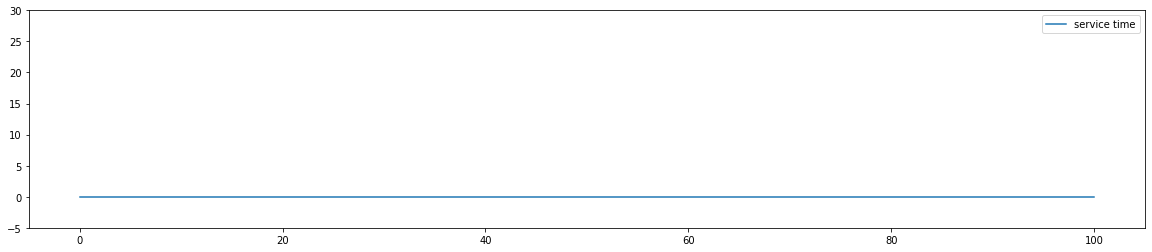

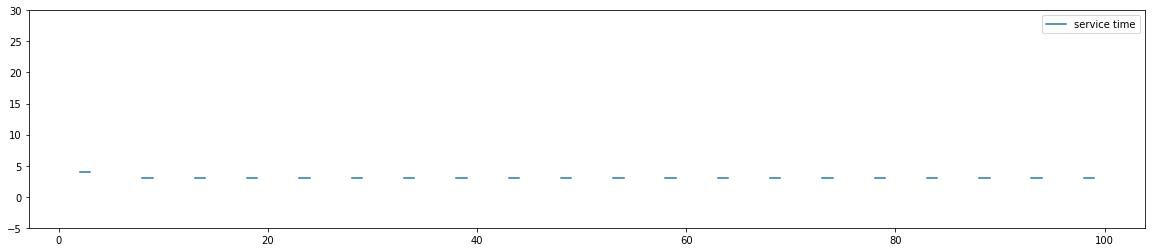

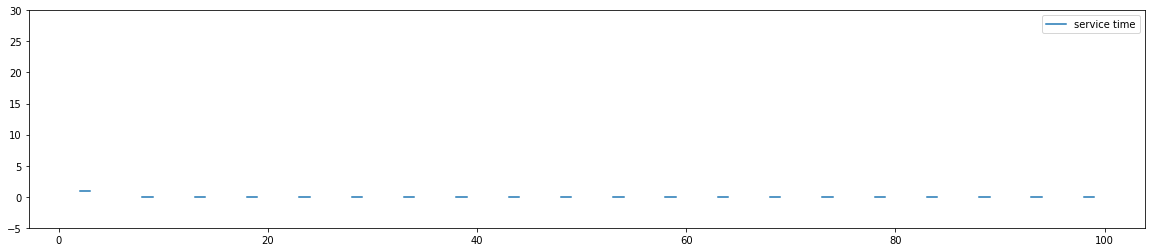

Inventory


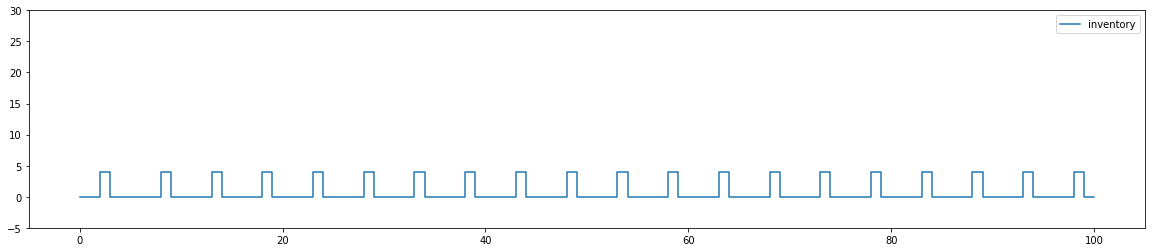

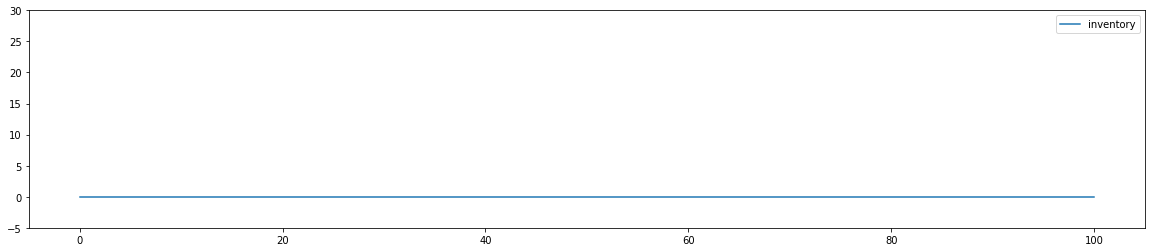

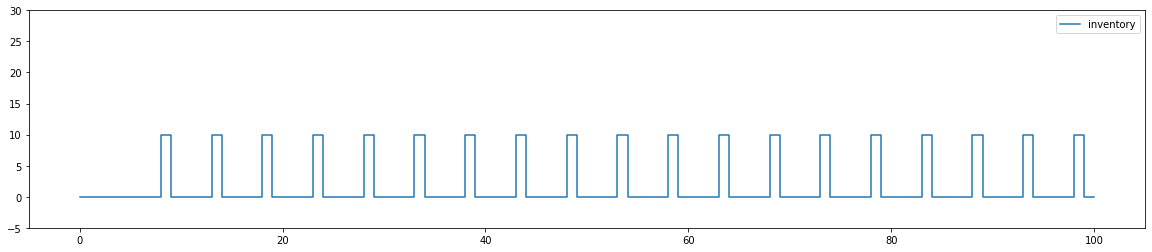

Rewards


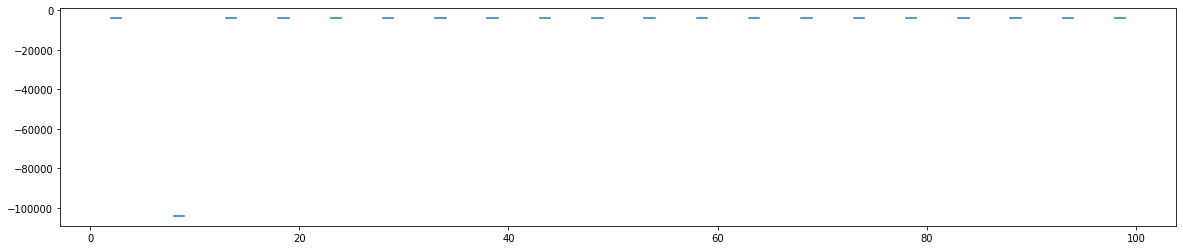

In [11]:
plannerAgent.policy_estimator.stdVal = 0
envParams["N"] = 100

print(envParams["inventoryCost"])
# play the game while training
stateHistory, actionHistory, rewardHistory, experiences = game.runEpisode(envParams, plannerAgent, train=False)

visualize(stateHistory, actionHistory, rewardHistory, envParams["N"])


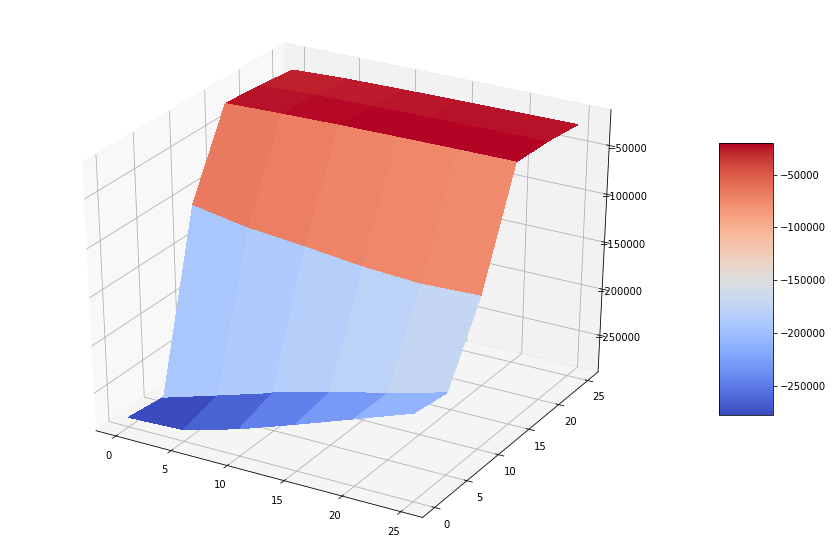

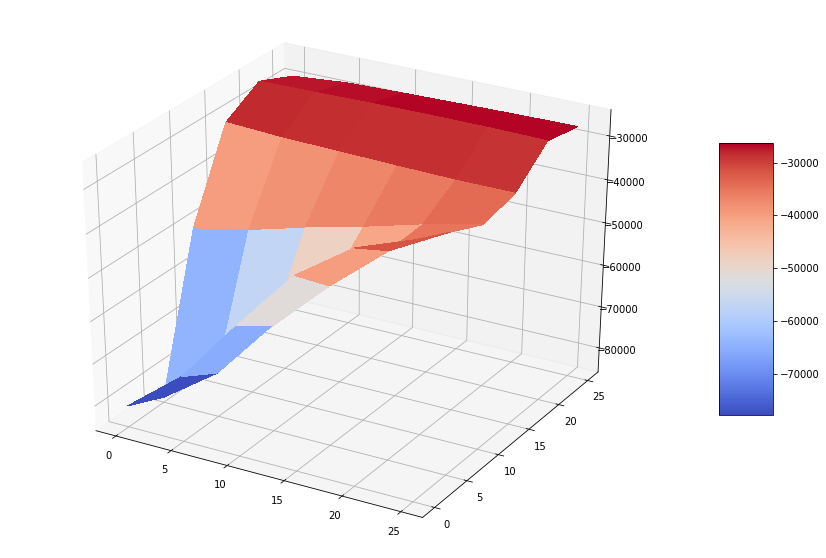

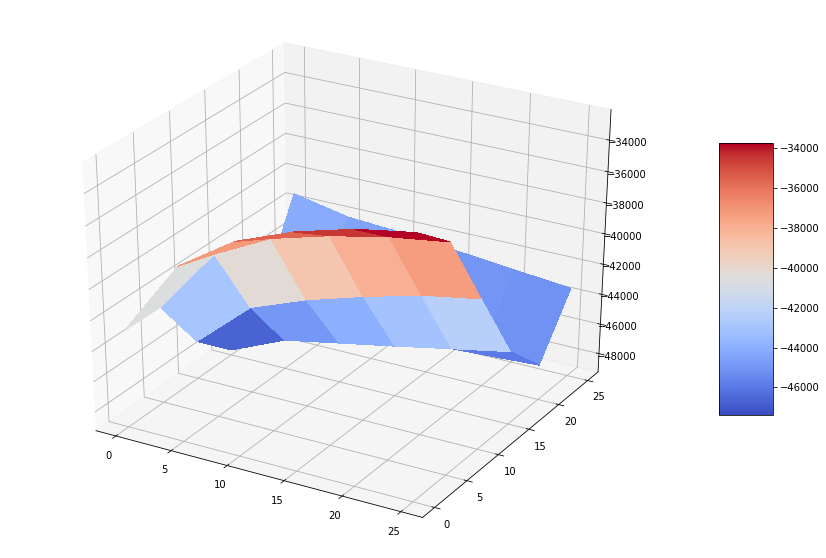

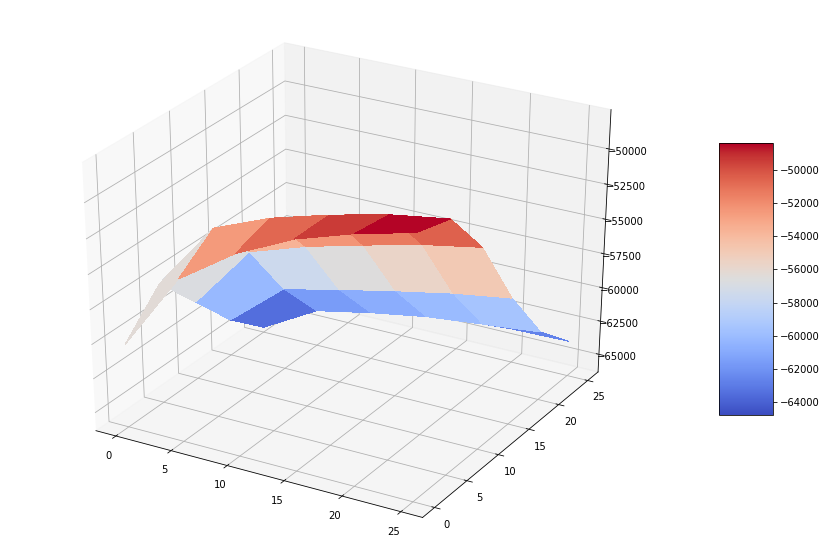

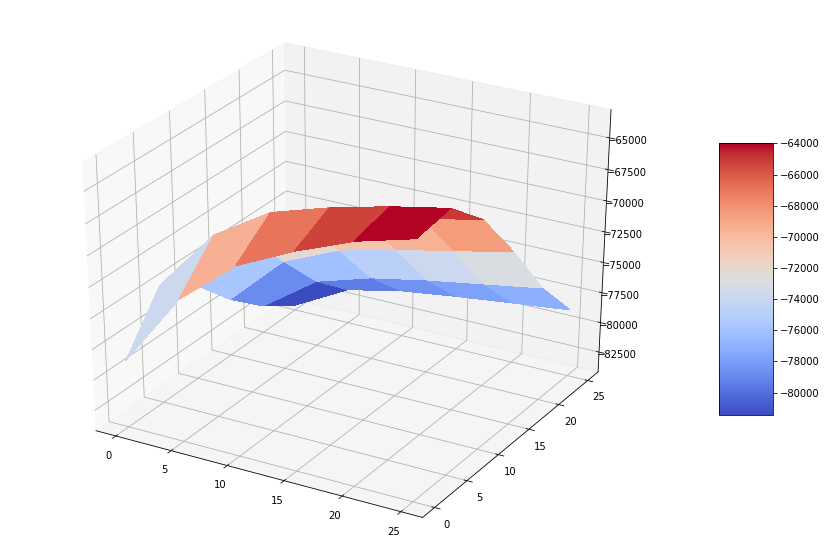

In [12]:
"""
Illustrate Value Network
proxy to objective function
"""
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm


for w in range(0, 20, 4):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.gca(projection='3d')
    # Make data.
    X = np.arange(0, 30, 5)
    Y = np.arange(0, 30, 5)
    X, Y = np.meshgrid(X, Y)

    Z = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            s = np.array([X[i,j], Y[i,j], w])
            state = np.reshape(s, (1, 3))
            z = plannerAgent.value_estimator.predict(state)
            Z[i, j] = z

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    # ax.set_zlim(-199.48181, -199.48180)
    # ax.view_init(30, 80)

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()


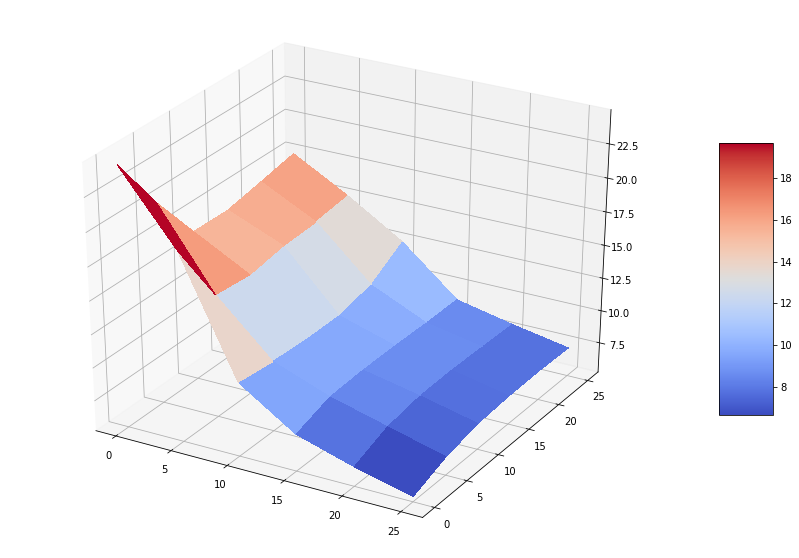

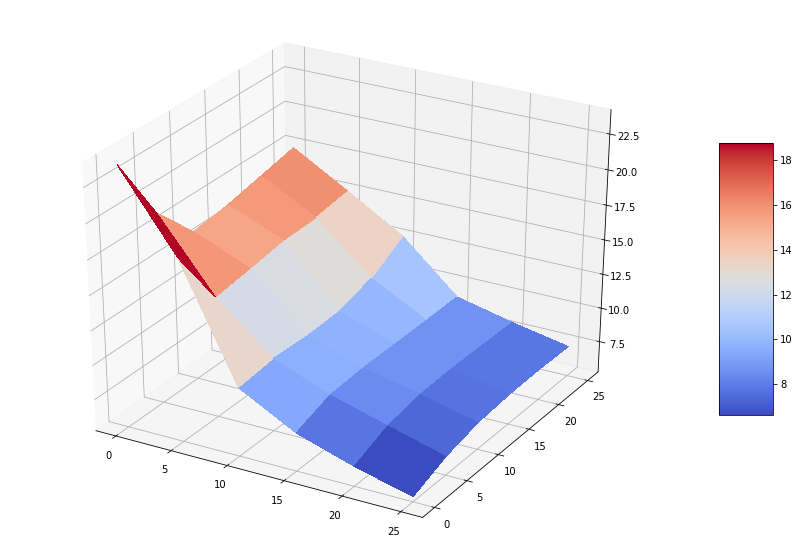

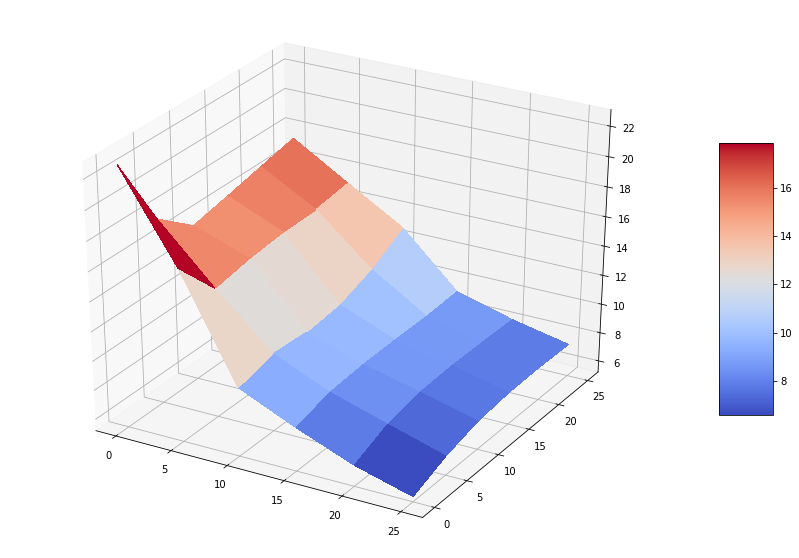

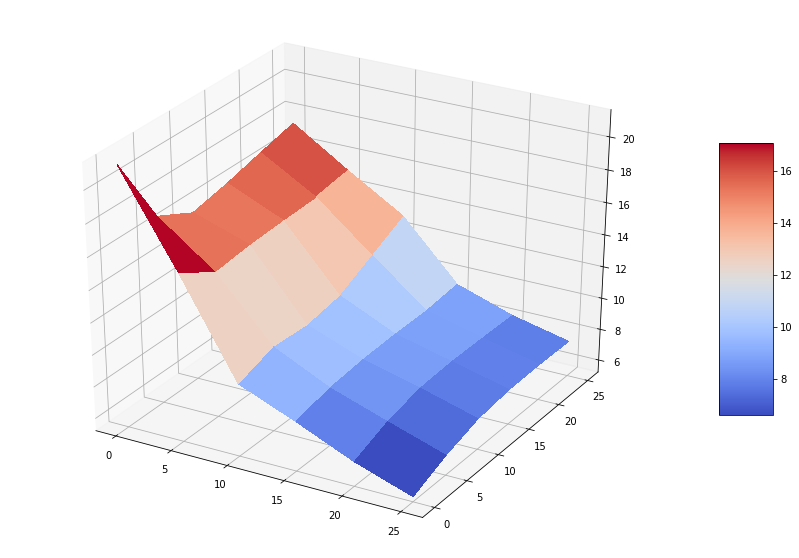

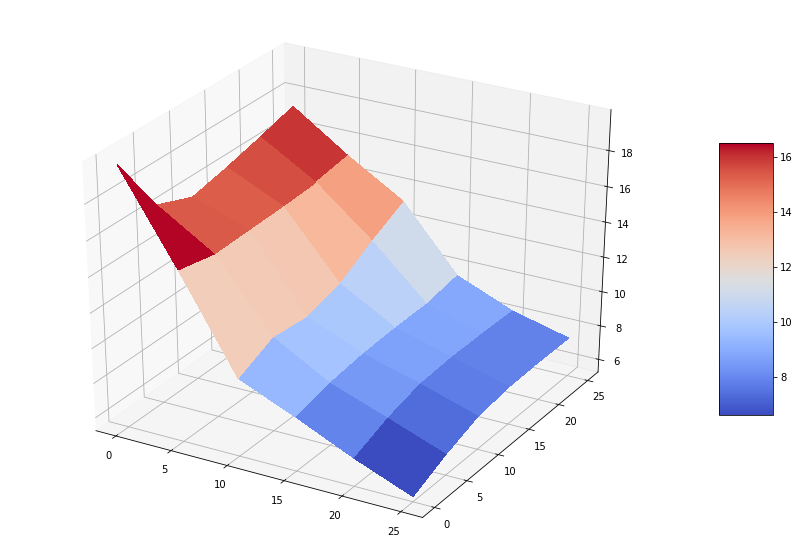

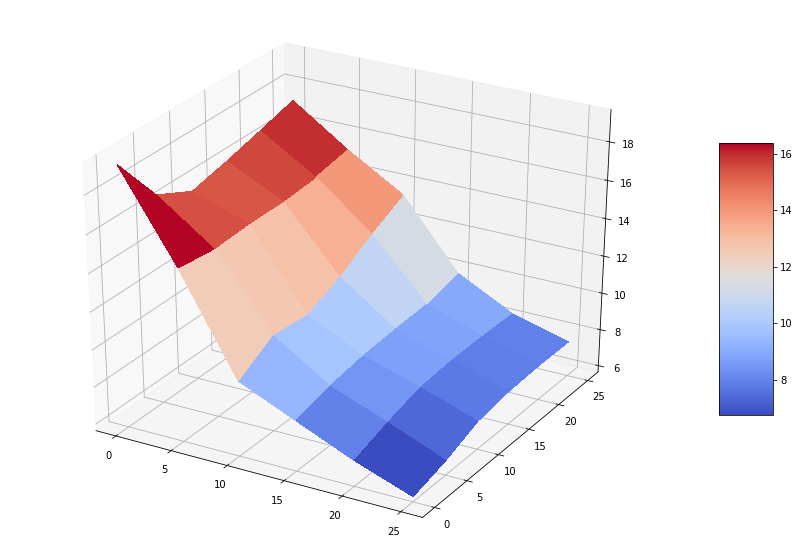

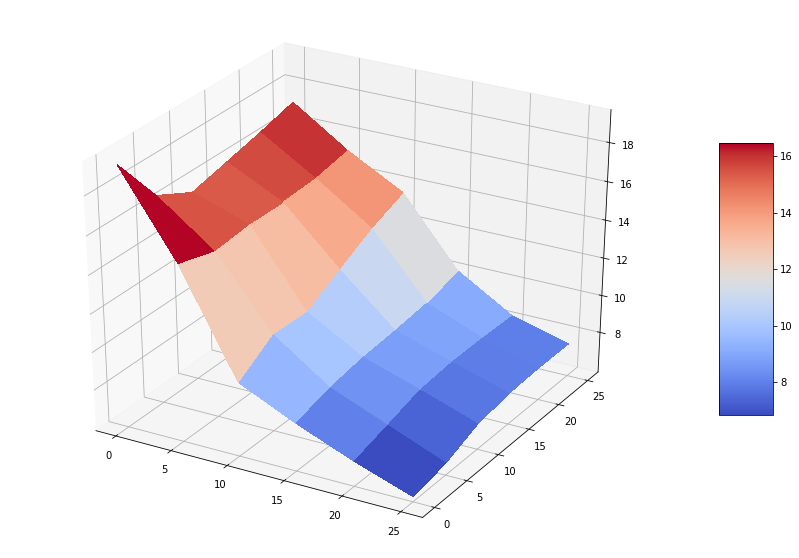

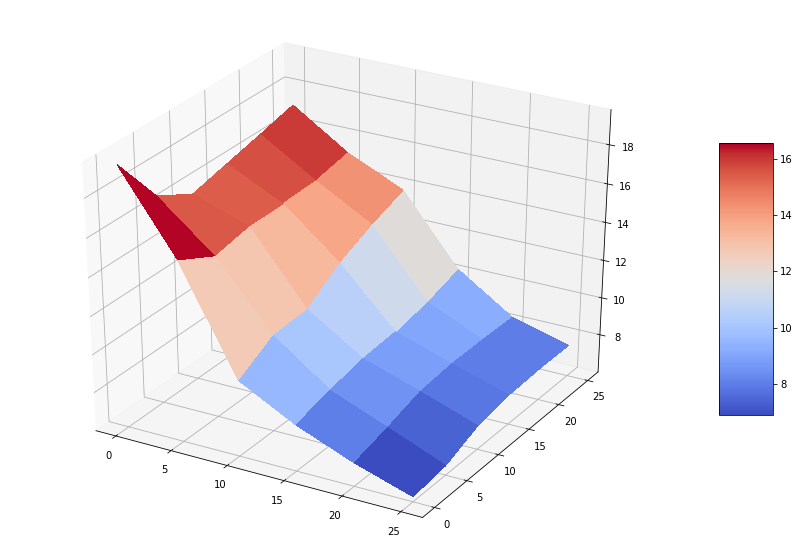

In [13]:
"""
Illustrate Policy Network
proxy to objective function
"""

from matplotlib import cm


for w in range(0, 8, 1):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.gca(projection='3d')
    # Make data.
    X = np.arange(0, 30, 5)
    Y = np.arange(0, 30, 5)
    X, Y = np.meshgrid(X, Y)

    Z = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            s = np.array([X[i,j], Y[i,j], w])
            state = s #np.reshape(s, (1, 3))
            mu, a = plannerAgent.policy_estimator.predict(state, capacity=[30, 30, 30], retailerOrderQty=10)
            z = mu[0]
            Z[i, j] = z

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    # ax.set_zlim(-199.48181, -199.48180)
    # ax.view_init(30, 80)

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()
